In [1]:
import pandas as pd

# Load the CSV file into a DataFrame to be used in the clustering process
df = pd.read_csv('Data/Partitioned_Abstracts.csv', sep=',', header=0, encoding='utf-8')

#verify that the DataFrame is loaded correctly
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1228 entries, 0 to 1227
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Title                 1228 non-null   object
 1   Year                  1228 non-null   int64 
 2   Authors               1228 non-null   object
 3   Label                 1228 non-null   object
 4   Partitioned Abstract  1228 non-null   object
 5   Target                1228 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 57.7+ KB


In [2]:
from sentence_transformers import SentenceTransformer

#Create the combined text by concatenating the "Title" and "Partitioned Abstract" columns
combined_texts = df["Title"].astype(str) + "\n\n" + df["Partitioned Abstract"].astype(str)
# Convert the "Target" column to integer type for classification purposes
targets = df["Target"].astype(int)

# Load the SentenceTransformer model for generating embeddings
model = SentenceTransformer("jinaai/jina-embeddings-v3", trust_remote_code=True)

# Define the task type for the model
task = "clustering"

# Encode the combined texts using the SentenceTransformer model
embeddings = model.encode(
    combined_texts.tolist(),
    show_progress_bar=True,
    device="cuda",
    convert_to_tensor=True,
)
embeddings.shape

flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Batches:   0%|          | 0/39 [00:00<?, ?it/s]

torch.Size([1228, 1024])

In [4]:
from sklearn.decomposition import PCA
import torch

# Move to CPU and convert to numpy (float32)
embeddings_np = embeddings.cpu().to(torch.float32).numpy()

# Reduce to 50 components (you can adjust n_components)
pca = PCA(n_components=50, random_state=42)
embeddings_pca = pca.fit_transform(embeddings_np)

In [5]:
from sklearn.mixture import GaussianMixture
import numpy as np

n_clusters = len(np.unique(targets))  # Number of clusters = number of unique classes

gmm = GaussianMixture(n_components=n_clusters, random_state=42)
labels_gmm = gmm.fit_predict(embeddings_np)

gmm_pca = GaussianMixture(n_components=n_clusters, random_state=42)
labels_gmm_pca = gmm_pca.fit_predict(embeddings_pca)


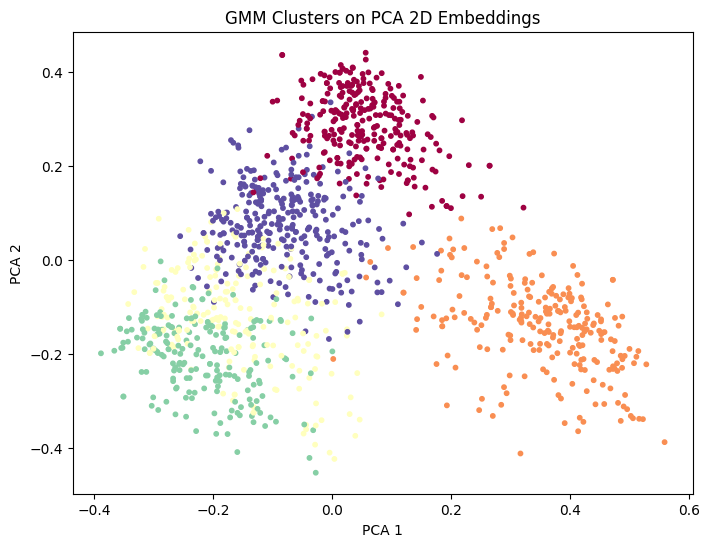

In [6]:
pca_2d = PCA(n_components=2, random_state=42)
embeddings_pca_2d = pca_2d.fit_transform(embeddings.cpu().to(torch.float32).numpy())

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_pca_2d[:, 0], embeddings_pca_2d[:, 1], c=labels_gmm_pca, s=10, cmap='Spectral')
plt.title("GMM Clusters on PCA 2D Embeddings")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


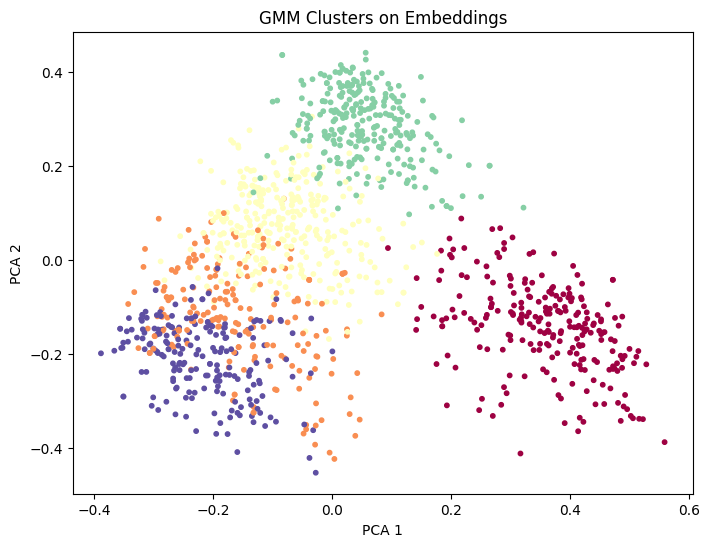

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_pca_2d[:, 0], embeddings_pca_2d[:, 1], c=labels_gmm, s=10, cmap='Spectral')
plt.title("GMM Clusters on Embeddings")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [27]:
import plotly.express as px
import pandas as pd

gmm = GaussianMixture(n_components=n_clusters, random_state=42)
pca_3d = PCA(n_components=3, random_state=42)
embeddings_pca_3d = pca_3d.fit_transform(embeddings_np)
labels_gmm_pca3d = gmm.fit_predict(embeddings_pca_3d)

df_plot = pd.DataFrame(embeddings_pca_3d, columns=["x", "y", "z"])
df_plot["Cluster"] = labels_gmm_pca3d 
df_plot["Title"] = df["Title"]
df_plot["Partitioned Abstract"] = df["Partitioned Abstract"].values

cluster_texts = {}
for label in np.unique(labels_gmm):
    cluster_texts[label] = df_plot[df_plot["Cluster"] == label]["Partitioned Abstract"].tolist()  # or use combined_texts


from bertopic import BERTopic

topic_labels = {}

for label, texts in cluster_texts.items():
    try:
        topic_model = BERTopic(
            # Optionally pass a custom vectorizer or representation model
            calculate_probabilities=False,
            verbose=False
        )
        topics, _ = topic_model.fit_transform(texts)
        top_topic_id = list(topic_model.get_topics().keys())[0]
        top_words = topic_model.get_topic(top_topic_id)
        # Get top 3 words as label
        label_text = ", ".join([word for word, _ in top_words[:3]])
        topic_labels[label] = label_text
    except Exception as e:
        print(f"[WARN] Cluster {label} failed: {e}")
        topic_labels[label] = f"Cluster {label}"


df_plot["ClusterLabel"] = df_plot["Cluster"].apply(
    lambda x: "Noise" if x == -1 else topic_labels.get(x, f"Cluster {x}")
)

fig = px.scatter_3d(
    df_plot, x="x", y="y", z="z",
    color="ClusterLabel",
    hover_name="Title",
    title="GMM Clusters in 3D PCA Space",
    opacity=0.8
)
fig.update_layout(scene=dict(
    xaxis_title="PCA 1",
    yaxis_title="PCA 2",
    zaxis_title="PCA 3",
    bgcolor="lightgrey"
))
fig.show()
fig.write_html("gmm_pca3d_clusters.html")


In [18]:
import plotly.express as px
import pandas as pd

df_plot = pd.DataFrame(embeddings_pca_3d, columns=["x", "y", "z"])
df_plot["Cluster"] = labels_gmm  # or labels_gmm_pca3d if fitted on 3D PCA
df_plot["Title"] = df["Title"]

df_plot["Partitioned Abstract"] = df["Partitioned Abstract"].values
cluster_texts = {}
for label in np.unique(labels_gmm):
    cluster_texts[label] = df_plot[df_plot["Cluster"] == label]["Partitioned Abstract"].tolist()  # or use combined_texts


from bertopic import BERTopic

topic_labels = {}

for label, texts in cluster_texts.items():
    try:
        topic_model = BERTopic(
            # Optionally pass a custom vectorizer or representation model
            calculate_probabilities=False,
            verbose=False
        )
        topics, _ = topic_model.fit_transform(texts)
        top_topic_id = list(topic_model.get_topics().keys())[0]
        top_words = topic_model.get_topic(top_topic_id)
        # Get top 3 words as label
        label_text = ", ".join([word for word, _ in top_words[:3]])
        topic_labels[label] = label_text
    except Exception as e:
        print(f"[WARN] Cluster {label} failed: {e}")
        topic_labels[label] = f"Cluster {label}"


df_plot["ClusterLabel"] = df_plot["Cluster"].apply(
    lambda x: "Noise" if x == -1 else topic_labels.get(x, f"Cluster {x}")
)

fig = px.scatter_3d(
    df_plot, x="x", y="y", z="z",
    color="ClusterLabel",
    hover_name="Title",
    title="GMM Clusters in 3D PCA Space",
    opacity=0.8
)
fig.update_layout(scene=dict(
    xaxis_title="PCA 1",
    yaxis_title="PCA 2",
    zaxis_title="PCA 3",
    bgcolor="lightgrey"
))
fig.show()
fig.write_html("gmm_clusters.html")


In [24]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score, silhouette_score
from scipy.optimize import linear_sum_assignment

def align_clusters(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    aligned = np.array([mapping.get(p, -1) for p in y_pred])
    return aligned

# No noise label with GMM, so no mask
true_labels = df["Target"].values
aligned_preds = align_clusters(true_labels, labels_gmm)
kappa = cohen_kappa_score(true_labels, aligned_preds)
print(f"Cohen’s Kappa (GMM on embeddings vs. Target): {kappa:.4f}")


Cohen’s Kappa (GMM on embeddings vs. Target): 0.7650


In [23]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score, silhouette_score
from scipy.optimize import linear_sum_assignment

def align_clusters(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    aligned = np.array([mapping.get(p, -1) for p in y_pred])
    return aligned

# No noise label with GMM, so no mask
true_labels = df["Target"].values
aligned_preds = align_clusters(true_labels, labels_gmm_pca)
kappa = cohen_kappa_score(true_labels, aligned_preds)
print(f"Cohen’s Kappa (GMM on PCA 2D embeddings vs. Target): {kappa:.4f}")


Cohen’s Kappa (GMM on PCA embeddings vs. Target): 0.7619


In [26]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score, silhouette_score
from scipy.optimize import linear_sum_assignment

def align_clusters(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    aligned = np.array([mapping.get(p, -1) for p in y_pred])
    return aligned

# No noise label with GMM, so no mask
true_labels = df["Target"].values
aligned_preds = align_clusters(true_labels, labels_gmm_pca3d)
kappa = cohen_kappa_score(true_labels, aligned_preds)
print(f"Cohen’s Kappa (GMM on PCA 3D embeddings vs. Target): {kappa:.4f}")


Cohen’s Kappa (GMM on PCA 3D embeddings vs. Target): 0.7192
